In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/jessicahoch/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


+ Generate data into a dataframe called `data` using numpy and pandas. Your data *must be different* from what was used in the examples already. Choose different parameters. The intention here is that you will test how changing parameters changes the results. Play around with trying out several different values. 

In [49]:
# fix a random seed
np.random.seed(12345)

data = pd.DataFrame({
    "years": np.arange(0, 25),
    "score": np.concatenate([
    np.random.poisson(5.0, 15),
    np.random.poisson(1.0,10),
    ])
})


missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "years"] = np.nan



In [31]:
data.head()


,score,years
0,4,0.0
1,7,1.0
2,7,NaN
3,8,3.0
4,3,4.0


+ Implement a model that is appropriate for the data you have simulated. This can be a simple regression model like in notebook 10.4, or a more complex one like in notebook 10.6. Choose something that is interesting to you. 

In [50]:
# plot the generated data
toyplot.scatterplot(
    data.years,
    data.score, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="years", 
    ylabel="score",
);

0 5 10 15 20 25 years 0 5 10 score

In [51]:
with pm.Model() as score_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.years.min(), 
        upper=data.years.max(), 
        testval=12)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.years, early_rate, late_rate)

    years = pm.Poisson('years', rate, observed=data.score)

In [52]:
with score_model:
    trace = pm.sample(10)

/Users/jessicahoch/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
 93%|█████████▎| 475/510 [00:00<00:00, 671.18it/s]/Users/jessicahoch/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 510/510 [00:00<00:00, 669.29it/s]
/Users/jessicahoch/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.


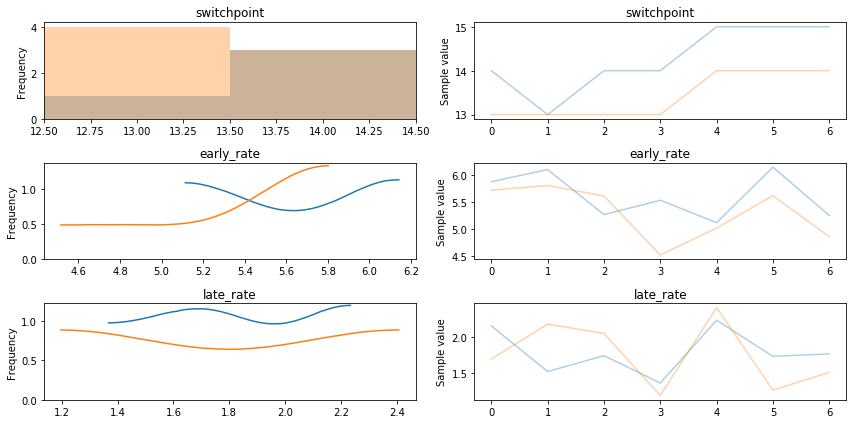

In [53]:
pm.traceplot(trace[3:]);

+ Fit your model, plot the trace, and print the summary. 


In [54]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,13.950000,0.864581,0.249499,13.000000,16.000000,6.0,0.951861
early_rate,5.455668,0.393160,0.086799,4.515851,6.141674,20.0,0.992838
late_rate,1.853345,0.384004,0.070354,1.197555,2.420912,20.0,0.951030


+ Using markdown, describe how closely your model predicted your generative parameters. Are your parameters within the 95% HPD interval? Do you think you ran the MCMC sampler long enough? Do you think anything went wrong? If so, what did you try to troubleshoot the problem? Did you seek help or answers?
